In [1]:
import json
import os
import warnings
from datetime import datetime
from shutil import copyfile

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pandas_profiling as pp
import xgboost as xgb
import seaborn as sns
import shap
from catboost import CatBoostClassifier, Pool, cv
from category_encoders import TargetEncoder, WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import (
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from tqdm import tqdm

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `easy numbers` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode

sns.set_context("paper", font_scale=1.4)

## Full dataset: 30k instances

### Load data

In [2]:
df = pd.read_csv("Data\\data_preprocessed\\taiwan_data_binned.csv", sep=",", na_values="NULL")
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,GOOD
0,1,1,2,1,1,2,2,-1,-1,-2,-2,3,3,2,1,1,1,1,2,1,1,1,1,0
1,5,1,2,2,2,-1,2,0,0,0,2,3,3,3,3,3,4,1,2,2,2,1,3,0
2,4,1,2,2,5,0,0,0,0,0,0,6,5,5,5,5,5,2,2,2,2,2,4,1
3,2,1,2,1,6,0,0,0,0,0,0,7,7,8,6,7,7,3,3,2,2,2,2,1
4,2,0,2,1,10,-1,0,-1,0,0,0,4,4,7,6,6,6,3,5,5,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,8,0,3,1,7,0,0,0,0,0,0,10,10,10,9,7,5,5,5,4,3,4,2,1
29996,6,0,3,2,8,-1,-1,-1,-1,0,0,2,3,3,4,4,1,3,4,5,1,1,1,1
29997,1,0,2,2,6,4,3,2,-1,0,0,3,3,3,6,6,6,1,1,5,4,3,3,0
29998,4,0,3,1,8,1,-1,0,0,0,-1,1,8,8,8,5,8,5,4,2,3,4,3,0


In [3]:
X = df.drop(["GOOD"], axis=1)
y = df["GOOD"]

In [4]:
encoder = WOEEncoder(cols=X.columns)
encoder.fit(X, y)

encoder.transform(X).head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-0.676851,0.079796,-0.091407,-0.076823,-0.247134,-2.064535,-1.483906,0.429365,0.406626,0.146619,0.124508,0.089539,0.100164,-0.011668,-0.063876,-0.101678,-0.054590,-0.605285,-0.109019,-0.519484,-0.381492,-0.332081,-0.350377
1,-0.042830,0.079796,-0.091407,0.070559,0.082730,0.342132,-1.483906,0.295227,0.235501,0.200886,-1.284484,0.089539,0.100164,0.107955,0.149203,0.158078,0.313852,-0.605285,-0.109019,-0.040077,-0.095252,-0.332081,0.084080
2,-0.135227,0.079796,-0.091407,0.070559,0.167216,0.658825,0.405975,0.295227,0.235501,0.200886,0.201431,-0.108566,-0.199442,-0.158970,-0.108127,-0.073599,-0.039862,-0.034394,-0.109019,-0.040077,-0.095252,-0.093755,0.487439
3,-0.273433,0.079796,-0.091407,-0.076823,0.021680,0.658825,0.405975,0.295227,0.235501,0.200886,0.201431,0.008049,-0.001207,0.031509,-0.149164,-0.108566,-0.146490,0.018956,0.043052,-0.040077,-0.095252,-0.093755,-0.110346
4,-0.273433,-0.115175,-0.091407,-0.076823,-0.176691,0.342132,0.405975,0.429365,0.235501,0.200886,0.201431,0.000298,0.040953,-0.075890,-0.149164,-0.174904,-0.215064,0.018956,0.627978,0.508244,0.470183,-0.093755,-0.110346


### Model definition

In [5]:
pipe = Pipeline([
    ("scaler", WOEEncoder()),
    ("lr", LogisticRegression())
])

### Model performance

In [6]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
scores = cross_validate(
    pipe, X, y, scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1
)

mean_train_auc = scores["train_score"].mean()
mean_test_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()
print("GINI train:", np.round(mean_train_auc * 2 - 1, 3))
print("GINI dev:", np.round(mean_test_auc * 2 - 1, 3), f"({np.round(std_test_auc, 3)})")

GINI train: 0.485
GINI dev: 0.482 (0.011)


### Model visualization

In [7]:
pipe = Pipeline([("scaler", WOEEncoder()), ("lr", LogisticRegression())])
pipe.fit(X, y)

coefs = pd.DataFrame(zip(X.columns, pipe['lr'].coef_[0]), columns=['Variable', 'Coef'])
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index))

     Variable      Coef
5       PAY_0 -0.513528
3    MARRIAGE  0.150114
6       PAY_2 -0.129933
18   PAY_AMT2  0.106160
1         SEX  0.087765
2   EDUCATION  0.085727
19   PAY_AMT3  0.079906
11  BILL_AMT1  0.078190
17   PAY_AMT1  0.073444
9       PAY_5 -0.071107
10      PAY_6 -0.064414
7       PAY_3 -0.062042
20   PAY_AMT4  0.060882
21   PAY_AMT5  0.056751
22   PAY_AMT6  0.053159
16  BILL_AMT6 -0.046158
15  BILL_AMT5  0.039737
8       PAY_4 -0.039378
13  BILL_AMT3 -0.031488
4         AGE -0.021574
14  BILL_AMT4 -0.013435
0   LIMIT_BAL  0.010647
12  BILL_AMT2  0.008255


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

encoder = WOEEncoder(cols=X.columns)
encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

pipe.fit(X = X_train, y = np.ravel(y_train))
preds = pipe.predict_proba(X_test)[::,1]
test_auc = metrics.roc_auc_score(y_test, preds)

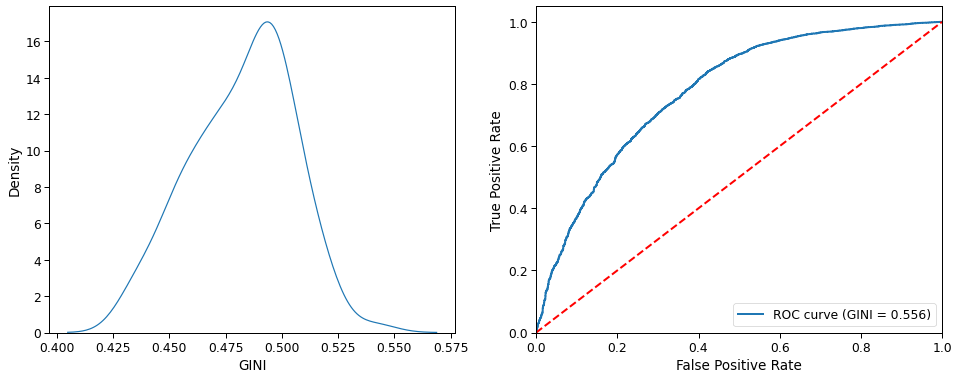

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
fig1 = sns.kdeplot(scores["test_score"]*2-1, ax=axs[0])
fig1.set_xlabel('GINI')
fig1.set_ylabel('Density')

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw=2
axs[1].plot(fpr, tpr, lw=lw, label='ROC curve (GINI = %0.3f)' % (test_auc * 2 - 1))
axs[1].plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend(loc="lower right")

plt.savefig('output.png', dpi=300)

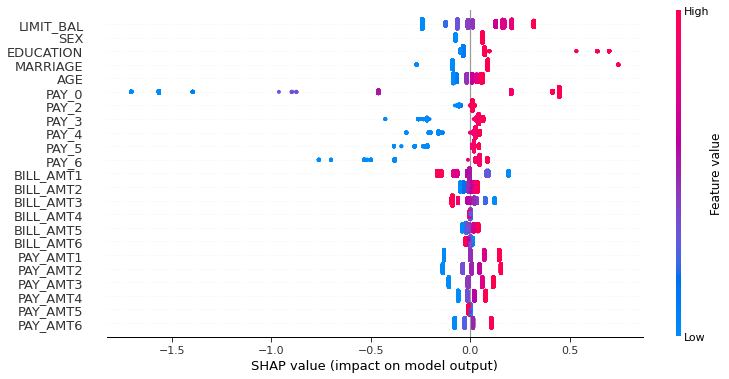

In [10]:
explainer = shap.Explainer(pipe['lr'], X_train, feature_names=X.columns)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=24, plot_size=(12,6), order=range(23))

## 1/3 dataset: 10k instances

### Load data

In [11]:
N_SAMPLES = 10000
df = pd.read_csv("Data\\data_preprocessed\\taiwan_data_binned.csv", sep=",", na_values="NULL").sample(N_SAMPLES, random_state=42)
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,GOOD
2308,1,0,2,2,1,0,0,0,0,0,0,4,4,4,5,5,5,2,3,3,2,2,3,1
22404,6,1,1,2,2,0,0,0,0,0,0,9,9,9,9,9,9,4,4,4,3,3,3,1
23397,3,1,3,1,5,0,0,0,0,0,0,8,8,8,8,9,9,3,4,4,3,3,3,1
25058,5,0,3,2,9,0,0,0,0,0,-1,5,5,5,5,5,4,2,3,5,1,4,4,1
2664,2,1,2,2,6,0,0,0,0,0,2,9,7,7,6,6,6,3,2,2,3,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16803,7,0,1,2,7,0,0,0,0,0,0,8,8,8,9,9,9,4,4,4,3,3,3,1
20133,5,1,3,2,9,0,0,0,0,0,0,7,7,7,8,1,8,3,3,3,3,1,3,0
24581,2,0,2,2,9,0,0,0,0,0,0,5,5,5,6,5,6,3,3,3,2,2,2,1
2018,4,1,3,1,6,0,0,0,0,0,0,7,7,8,7,5,5,3,3,3,2,2,3,1


In [12]:
X = df.drop(["GOOD"], axis=1)
y = df["GOOD"]

In [13]:
encoder = WOEEncoder(cols=X.columns)
encoder.fit(X, y)

encoder.transform(X).head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
2308,-0.585638,-0.103636,-0.076874,0.081867,-0.229392,0.642972,0.375651,0.273989,0.23279,0.208939,0.226553,0.005656,0.065190,0.115883,-0.144911,-0.106453,0.001085,-0.123397,0.078055,-0.025782,-0.031113,-0.078243,0.015219
22404,0.317473,0.072662,0.143415,0.081867,0.041140,0.642972,0.375651,0.273989,0.23279,0.208939,0.226553,0.221622,0.142638,0.079958,0.083163,0.076781,-0.033020,0.230072,0.210574,0.231380,0.060086,0.050024,0.015219
23397,-0.453546,0.072662,-0.155042,-0.089903,0.184794,0.642972,0.375651,0.273989,0.23279,0.208939,0.226553,-0.019566,0.022475,0.058730,0.003905,0.076781,-0.033020,-0.006732,0.210574,0.231380,0.060086,0.050024,0.015219
25058,-0.170979,-0.103636,-0.155042,0.081867,-0.171951,0.642972,0.375651,0.273989,0.23279,0.208939,0.253015,-0.161350,-0.195239,-0.206613,-0.144911,-0.106453,0.255646,-0.123397,0.078055,0.482214,-0.402569,0.473555,0.464380
2664,-0.261071,0.072662,-0.076874,0.081867,0.017652,0.642972,0.375651,0.273989,0.23279,0.208939,-1.321944,0.221622,-0.026497,-0.075038,0.012485,-0.141408,-0.163927,-0.006732,-0.176260,-0.038619,0.060086,-0.345210,-0.026329


### Model definition

In [14]:
pipe = Pipeline([
    ("scaler", WOEEncoder()),
    ("lr", LogisticRegression())
])

### Model performance

In [15]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
scores = cross_validate(
    pipe, X, y, scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1
)

mean_train_auc = scores["train_score"].mean()
mean_test_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()
print("GINI train:", np.round(mean_train_auc * 2 - 1, 3))
print("GINI dev:", np.round(mean_test_auc * 2 - 1, 3), f"({np.round(std_test_auc, 3)})")

GINI train: 0.485
GINI dev: 0.476 (0.022)


## 1/15 dataset: 1k instances

### Load data

In [16]:
N_SAMPLES = 2000
df = pd.read_csv("Data\\data_preprocessed\\taiwan_data_binned.csv", sep=",", na_values="NULL").sample(N_SAMPLES, random_state=42)
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,GOOD
2308,1,0,2,2,1,0,0,0,0,0,0,4,4,4,5,5,5,2,3,3,2,2,3,1
22404,6,1,1,2,2,0,0,0,0,0,0,9,9,9,9,9,9,4,4,4,3,3,3,1
23397,3,1,3,1,5,0,0,0,0,0,0,8,8,8,8,9,9,3,4,4,3,3,3,1
25058,5,0,3,2,9,0,0,0,0,0,-1,5,5,5,5,5,4,2,3,5,1,4,4,1
2664,2,1,2,2,6,0,0,0,0,0,2,9,7,7,6,6,6,3,2,2,3,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23791,3,1,2,1,10,2,2,2,0,0,0,8,8,8,8,7,7,5,1,4,2,2,3,0
23667,7,1,2,1,8,-1,-1,-1,-1,-1,-1,3,1,3,3,2,3,1,2,3,2,2,2,1
5282,5,1,2,1,5,0,0,0,0,0,0,9,9,9,10,10,10,4,4,4,4,4,4,1
5214,9,0,3,1,10,0,0,2,0,0,2,6,6,5,5,6,6,4,1,2,3,1,2,1


In [17]:
X = df.drop(["GOOD"], axis=1)
y = df["GOOD"]

In [18]:
encoder = WOEEncoder(cols=X.columns)
encoder.fit(X, y)

encoder.transform(X).head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
2308,-0.436937,-0.131180,0.025457,0.106471,-0.242604,0.562017,0.344366,0.263645,0.245115,0.196043,0.265933,0.170241,0.082489,-0.100163,-0.071003,-0.153726,0.045448,-0.160327,0.109504,-0.090946,-0.145327,-0.115715,-0.019213
22404,0.358920,0.092243,0.058569,0.106471,0.355400,0.562017,0.344366,0.263645,0.245115,0.196043,0.265933,0.241413,0.232436,0.147028,-0.101232,-0.174904,-0.138972,0.355960,0.339652,0.329604,-0.020570,0.105546,-0.019213
23397,-0.287258,0.092243,-0.276208,-0.105734,0.125698,0.562017,0.344366,0.263645,0.245115,0.196043,0.265933,-0.174187,-0.097148,-0.159200,0.094077,-0.174904,-0.138972,-0.136402,0.339652,0.329604,-0.020570,0.105546,-0.019213
25058,-0.266638,-0.131180,-0.276208,0.106471,-0.234005,0.562017,0.344366,0.263645,0.245115,0.196043,0.224806,-0.138972,-0.174904,-0.279345,-0.071003,-0.153726,0.011428,-0.160327,0.109504,0.467220,-0.356987,0.444098,0.556893
2664,-0.250890,0.092243,0.025457,0.106471,-0.187174,0.562017,0.344366,0.263645,0.245115,0.196043,-1.341667,0.241413,0.030549,0.002068,0.233194,0.003566,-0.243133,-0.136402,-0.267474,-0.108842,-0.020570,-0.338264,-0.033023


### Model definition

In [19]:
pipe = Pipeline([
    ("scaler", WOEEncoder()),
    ("lr", LogisticRegression())
])

### Model performance

In [20]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
scores = cross_validate(
    pipe, X, y, scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1
)

mean_train_auc = scores["train_score"].mean()
mean_test_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()
print("GINI train:", np.round(mean_train_auc * 2 - 1, 3))
print("GINI dev:", np.round(mean_test_auc * 2 - 1, 3), f"({np.round(std_test_auc, 3)})")

GINI train: 0.491
GINI dev: 0.448 (0.045)
